In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error)
from sklearn.model_selection import train_test_split

In [3]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## У нас есть функция f

In [4]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

## Задание 1. Градиентный спуск для функции . Напишем функцию, выяиляющую градиент нашей функции f

In [5]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    
    return 2*np.sin(w)*np.cos(w)
    
    pass

In [6]:
w = np.array([1, 2])

## Проверим, что градиент считается, как надо

In [7]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"


## Реализуем градиентный спуск

In [8]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr*grad_f(curr_w)

    return np.vstack(history)

## Визуализируем точки градиентного спуска на 3D-графике нашей функции. 

In [9]:
import sys
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.gca(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

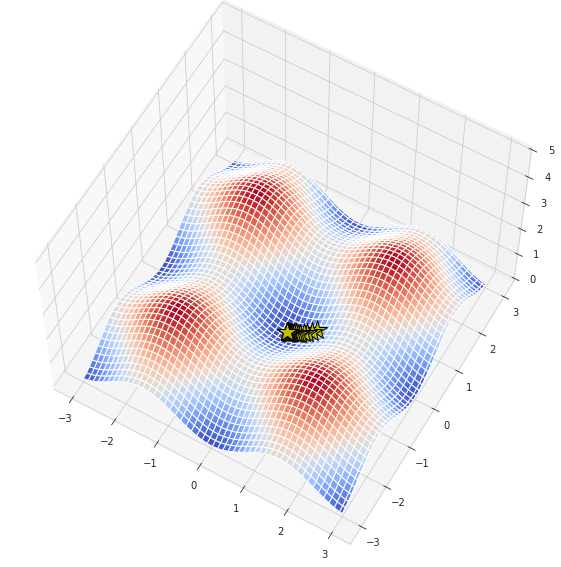

In [10]:
steps = gradient_desc_vis(f, grad_f)

## Посмотрим на зависимость значения функции от шага градиентного спуска.

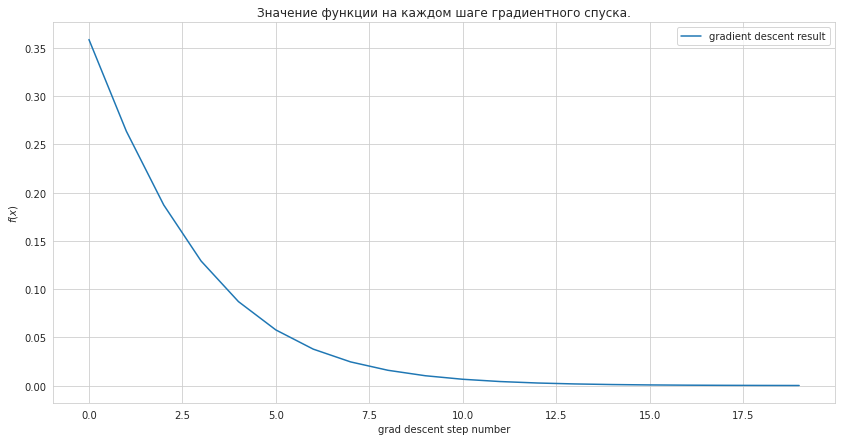

In [11]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге градиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

## Задание 2 Реализация линейной регресии
### Задание 2.1. MSE и ее градиент

In [13]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
    summa = 0
    for i in range(len(y_pred)):
      dist = (y_true[i] - y_pred[i]) ** 2
      summa += dist
    mse = (1/len(y_pred)) * (summa)
    return mse
    
    pass


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
    
    xTrans = X.transpose()
    return 2/(len(y_true)) * xTrans @ (y_pred - y_true)

    
    pass


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

## Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [14]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

## реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий

In [15]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

## Задание 2.2. Предсказания линейной регрессии 
### Реализуйте метод predict у класса CustomLinearRegression, не забудьте про свободный член!

In [17]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
        
        return X_test @ self.W    

        pass
    
    
    def __repr__(self):
        return "My custom linear regression"

## Проверим нашу реализацию на простом примере

In [26]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

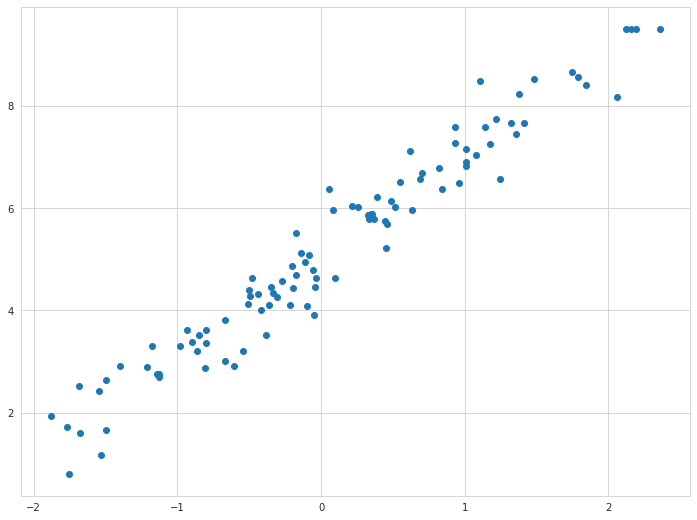

In [27]:
plt.scatter(X, y);

In [28]:
custom_lin_reg = CustomLinearRegression()

In [29]:
custom_lin_reg.fit(X, y)

My custom linear regression

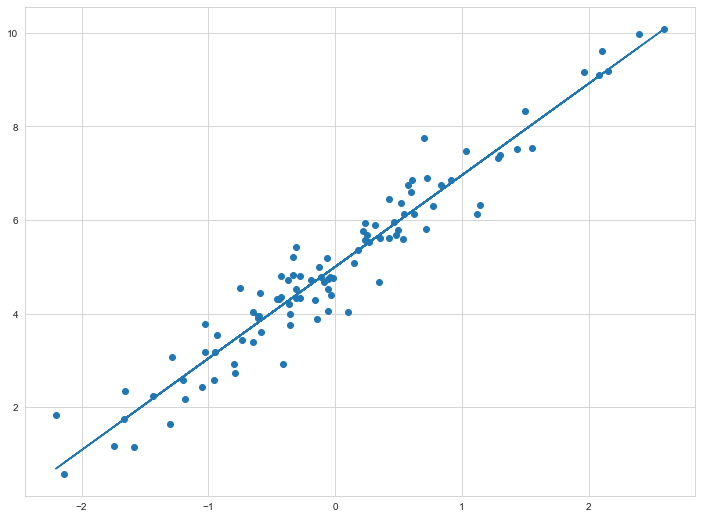

In [22]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

## Задание 2.3. Используем встроенную линейную регрессию (4 балла)

In [88]:
data = load_boston()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

C:\Users\User\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

In [89]:
X.shape #тут собрано 13 фичей, определяющий стоимость домов

(506, 13)

In [67]:
y.shape #тут таргетная переменная

(506,)

C:\Users\User\Miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

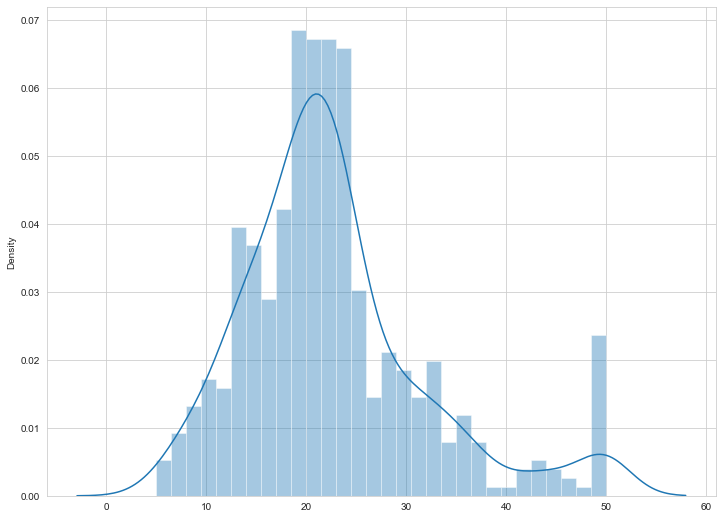

In [68]:
sns.distplot(y, bins=30) #посмотрим распределение таргетной переменной, более менее нормально с парой выбросов

In [69]:
housing = pd.DataFrame(X) #сделаем датафрейм Пандас чтобы на данные посмотреть

In [70]:
housing['target'] = y #добавим туда целевую переменную

In [71]:
housing

,0,1,2,3,4,5,6,7,8,9,10,11,12,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


<AxesSubplot:>

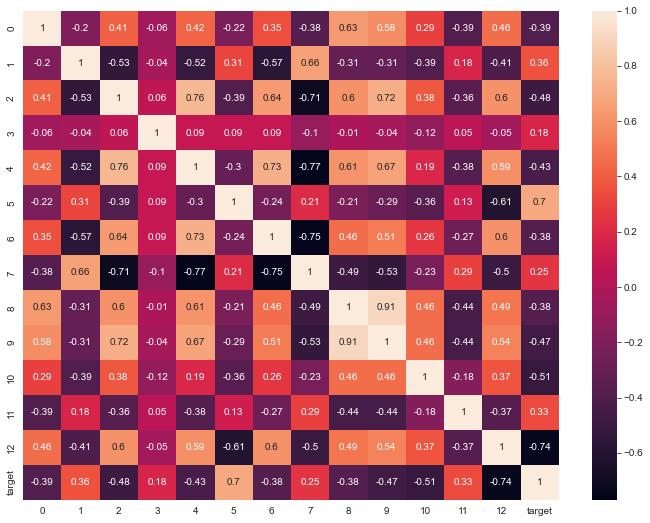

In [72]:
correlation_matrix = housing.corr().round(2) #построим матрицу корреляций и узнаем попарно все значения коэффициентов корреляций между колонками
sns.heatmap(data=correlation_matrix, annot=True) #для модели линейной регрессии есть смысл брать фичу 12, 5

In [91]:
X = pd.DataFrame(X) #сделаем X и y тоже pandas датафреймами

y = pd.DataFrame(y)
X

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [74]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=SEED) #разделим на трейн и тест

In [75]:
scaler = StandardScaler() #создадим скейлер
scaler.fit(X_train) #обучим его на трейне
X_train_scaled = scaler.transform(X_train) #трансформируем трейн и тест
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[-0.45258379,  1.99069364, -1.09212961, ..., -0.44623738,
         0.43831535, -0.7982498 ],
       [-0.43324857, -0.46476415, -0.56670775, ...,  0.49885324,
         0.43831535, -0.79539364],
       [-0.42801526,  0.51741897, -0.78855254, ...,  0.26258059,
         0.17228674, -0.03851286],
       ...,
       [ 1.66226467, -0.46476415,  0.99788178, ...,  0.78238043,
         0.13141794,  0.76549446],
       [ 0.01646241, -0.46476415,  0.99788178, ...,  0.78238043,
        -0.02322958, -1.06815634],
       [-0.44767689, -0.46476415, -0.88633938, ...,  0.78238043,
         0.43831535, -0.49692556]])

In [76]:
LinRegModel = LinearRegression()
LinRegModel.fit(X_train_scaled, y_train) #обучили модель линейной регрессии из библиотеки sklearn на трейне ,со стандартизацией

LinearRegression()

In [77]:
y_pred = LinRegModel.predict(X_test_scaled) #предсказываем значения для теста

In [78]:
print("MSE", mean_squared_error(y_test, y_pred)) #узнаем основные метрики

MSE 23.894614918192


In [79]:
print("RMSE", np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE 4.888211832377153


In [80]:
print("R2", r2_score(y_test, y_pred))

R2 0.7594226591833699


In [81]:
print("Coefficients: \n", LinRegModel.coef_) #посмотрим на коэффициенты. судя по ним, наибольший вес имеют фичи c номерами 12,7,8,4,5

Coefficients: 
 [[-0.7876521   1.15349541  0.02963376  0.55162011 -1.71764082  2.31245482
  -0.30049013 -3.01883409  2.42314188 -1.7758625  -1.96531116  0.99216327
  -3.77818397]]


<font size=3 color='purple'><b>Некорректно сравнивать веса коэффициентов при ненормализованных признаках.</b></font>


## переделала со стандартизацией

In [92]:
X = X.drop([2, 6, 3], axis='columns') #удалим колонки 2, 6, 3, они чет имеют небольшой вклад в модель
X

,0,1,4,5,7,8,9,10,11,12
0,0.00632,18.0,0.538,6.575,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,0.469,6.421,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,0.469,7.185,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,0.458,6.998,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,0.458,7.147,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,0.573,6.593,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,0.573,6.120,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,0.573,6.976,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,0.573,6.794,2.3889,1.0,273.0,21.0,393.45,6.48


In [93]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=SEED) #разделим на трейн и тест

scaler = StandardScaler() #создадим скейлер
scaler.fit(X_train) #обучим его на трейне
X_train_scaled = scaler.transform(X_train) #трансформируем трейн и тест
X_test_scaled = scaler.transform(X_test)

X_train_scaled

array([[-0.45258379,  1.99069364, -0.62527335, ..., -0.44623738,
         0.43831535, -0.7982498 ],
       [-0.43324857, -0.46476415, -0.54708725, ...,  0.49885324,
         0.43831535, -0.79539364],
       [-0.42801526,  0.51741897, -1.08570262, ...,  0.26258059,
         0.17228674, -0.03851286],
       ...,
       [ 1.66226467, -0.46476415,  0.20871174, ...,  0.78238043,
         0.13141794,  0.76549446],
       [ 0.01646241, -0.46476415,  1.4075653 , ...,  0.78238043,
        -0.02322958, -1.06815634],
       [-0.44767689, -0.46476415, -0.35596567, ...,  0.78238043,
         0.43831535, -0.49692556]])

In [97]:
LinRegModel = LinearRegression() #cнова зададим модель и обучим на трейн и тест
LinRegModel.fit(X_train_scaled, y_train)
y_pred = LinRegModel.predict(X_test_scaled)
print("MSE", mean_squared_error(y_test, y_pred)) #посчитаем метрики, вот только не сильно они улучшились

MSE 24.461666763056986


In [98]:
print("RMSE", np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE 4.945873710787305


In [99]:
print("R2", r2_score(y_test, y_pred))

R2 0.7537134303295113


<font size=3 color='purple'><b>Константы стандартизации необходимо рассчитывать только на тренировочном множестве, и уже их использовать для тестового множества при оценке метрик. <font color='red'>-0.5 баллов</font><br>P.S. А почему ты заново начала делать пайплайн?</b></font>


### Я передалала со стандартизацией
### Это я хотела попробовать удалить колонки, которые, как мне казалось, вносят мало эффекта в модель, я надеялась, что показатели улучшатся, но что-то нет

## Задание 3. Реализация логистической регресии 

### Задание 3.1. Реализация сигмоиды 

In [22]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    return 1/(np.exp(-(output)) + 1)
    pass


### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

In [11]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    return -(sum(y_true * np.log((y_pred) + (1 - y_true) * np.log(1 - y_pred))))/len(y_pred)
    pass
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
    
    xTrans = X.transpose()
    return xTrans @ (y_pred - y_true)
    pass


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

<font size=3 color='purple'><b>Ошибка в реализации BCE: во-первых, y_pred - это и так уже значение сигмоиды (а ты, получается, берешь её второй раз), кроме того, нет усреднения. <font color='red'>-1 балл</font><br></b></font>


## написала функцию bce по-другому

## Задание 3.3. Предсказания логистической регрессии 

In [17]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        predictions = X_test @ self.W
        return sigmoid(predictions)
        pass
    
    
    def __repr__(self):
        return "My custom logistic regression"

### Снова проверим работу алгоритма на простом примере

In [18]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

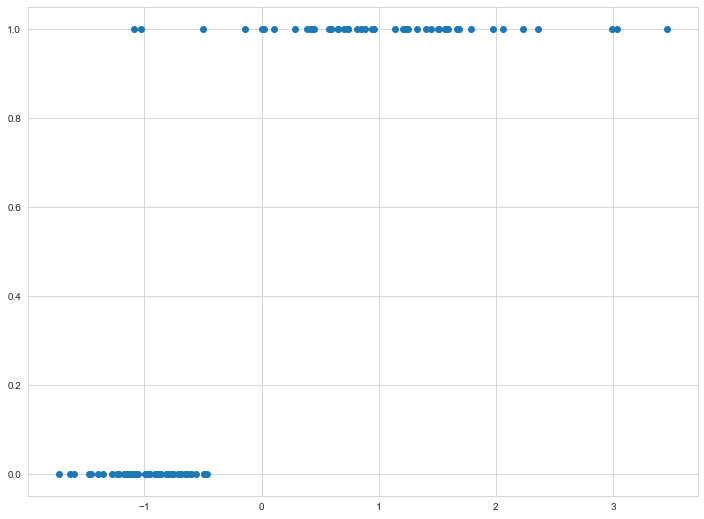

In [19]:
plt.scatter(X, y);

In [23]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)
y_pred[1, 0]

0.9970191145154885

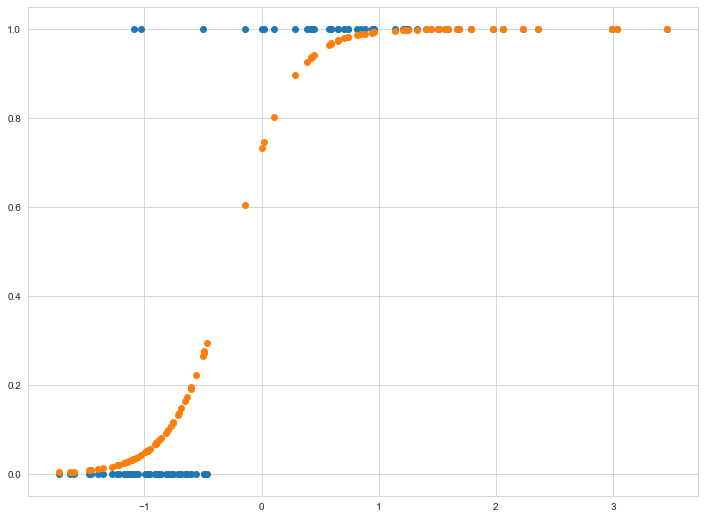

In [24]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

In [25]:
y_pred_classes = np.zeros(shape=(len(y_pred), )) #создадим пустой вектор с нулями длиной как y
y_pred_classes[0]

0.0

In [26]:
for i in range(len(y_pred)): #заполним вектор классами 0 или 1 в заисимости от предказанной вероятности
    if y_pred[i, 0] > 0.5:
        y_pred_classes[i] = 1
    else:
        y_pred_classes[i] = 0
y_pred_classes

array([1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
       1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1.])

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score #посчитаем основные метрики бинарной классификации
precision_score(y, y_pred_classes)

1.0

In [28]:
recall_score(y, y_pred_classes)

0.94

In [29]:
f1_score(y, y_pred_classes)

0.9690721649484536

In [30]:
accuracy_score(y, y_pred_classes)

0.97

## Задание 3.4. Применение логистической регрессии 

In [100]:
pokemon = pd.read_csv("Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [101]:
pokemon.loc[(pokemon.Legendary == True), 'Legendary'] = 1
pokemon.loc[(pokemon.Legendary == False), 'Legendary'] = 0

In [102]:
pokemon.Legendary

0      0
1      0
2      0
3      0
4      0
      ..
795    1
796    1
797    1
798    1
799    1
Name: Legendary, Length: 800, dtype: object

In [103]:
pokemon = pokemon.astype({'Legendary': 'int64'}) #переведем таргет в численную переменную, посмотрим остальные типы. Колонка "имя" явно не влияет на предсказание, ее можно убрать

In [104]:
pokemon.info() #в другой категориальной переменной Type2 многовато NaN, ее тоже можно не брать

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    int64 
dtypes: int64(10), object(3)
memory usage: 81.4+ KB


In [105]:
pd.unique(pokemon['Type 1']) #в переменной Type1 оч много уникальных значений, они внесут оч многокоэффициентов в модель, тоже можноубрать

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

In [106]:
pd.unique(pokemon['Type 2'])#в переменной Type2 оч много уникальных значений, они внесут оч многокоэффициентов в модель, тоже можноубрать

array(['Poison', nan, 'Flying', 'Dragon', 'Ground', 'Fairy', 'Grass',
       'Fighting', 'Psychic', 'Steel', 'Ice', 'Rock', 'Dark', 'Water',
       'Electric', 'Fire', 'Ghost', 'Bug', 'Normal'], dtype=object)

<font size=3 color='purple'><b>Непонятное обоснование. А если бы уникальных значений было на 5 меньше, мы бы их оставили? Создаётся впечатление, что все категориальные признаки исключаются только из соображений удобства без реального исследования значимости. <font color='red'>-0.5 баллов</font>

In [107]:
pokemon = pokemon.drop(['#','Name', 'Type 1', 'Type 2'], axis='columns') 
pokemon
#дропаем колонки с категориальными переменными имени и типов, а еще номер

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,318,45,49,49,65,65,45,1,0
1,405,60,62,63,80,80,60,1,0
2,525,80,82,83,100,100,80,1,0
3,625,80,100,123,122,120,80,1,0
4,309,39,52,43,60,50,65,1,0
...,...,...,...,...,...,...,...,...,...
795,600,50,100,150,100,150,50,6,1
796,700,50,160,110,160,110,110,6,1
797,600,80,110,60,150,130,70,6,1
798,680,80,160,60,170,130,80,6,1


In [110]:
X = pokemon.drop(['Legendary'],axis='columns') #дропаем таргет
X

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
0,318,45,49,49,65,65,45,1
1,405,60,62,63,80,80,60,1
2,525,80,82,83,100,100,80,1
3,625,80,100,123,122,120,80,1
4,309,39,52,43,60,50,65,1
...,...,...,...,...,...,...,...,...
795,600,50,100,150,100,150,50,6
796,700,50,160,110,160,110,110,6
797,600,80,110,60,150,130,70,6
798,680,80,160,60,170,130,80,6


In [111]:
y = pd.DataFrame(pokemon['Legendary']) #сохраеям таргет в y
y

,Legendary
0,0
1,0
2,0
3,0
4,0
...,...
795,1
796,1
797,1
798,1


In [112]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=SEED) #разделим на трейн и тест
X_train
scaler = StandardScaler() #создадим скейлер
scaler.fit(X_train) #обучим его на трейне
X_train_scaled = scaler.transform(X_train) #трансформируем трейн и тест
X_test_scaled = scaler.transform(X_test)





In [113]:
LogModel = LogisticRegression() #найдем коэффициенты модели. по-видимому, самый большой вклад в легендарность имеет признак скорости покемона
LogModel.fit(X_train_scaled, y_train)
print("Coefficients: \n", LogModel.coef_)

Coefficients: 
 [[1.08028581 0.33049786 0.35123626 0.66373018 0.82440962 1.01995798
  1.15051216 0.74342673]]


C:\Users\User\Miniconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<font size=3 color='purple'><b>Здесь и ранее вижу, что ты интерпретируешь коэффициенты лин. регрессии без предварительной нормализации данных. Признаки варьируются в различных по масштабу диапазонах, в таком случае нельзя напрямую сравнивать коэффициенты друг с другом. <font color='red'>-0.5 баллов</font>

### Переделала

C:\Users\User\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


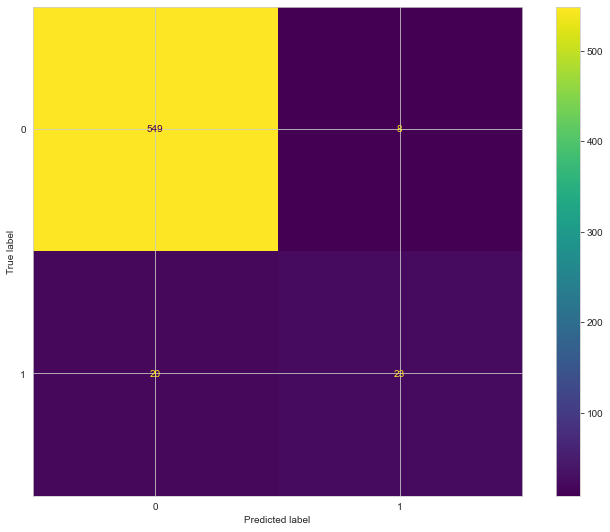

In [114]:
import sklearn
sklearn.metrics.plot_confusion_matrix(LogModel, X_train_scaled, y_train) #изобразим confusion matrix для train

C:\Users\User\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


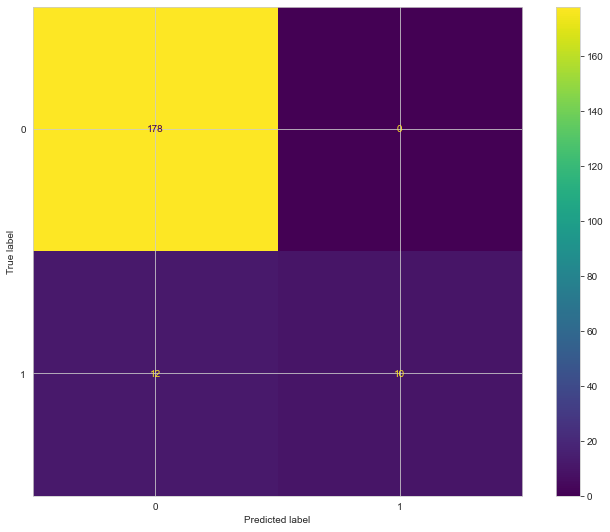

In [115]:
sklearn.metrics.plot_confusion_matrix(LogModel, X_test_scaled, y_test) ##изобразим confusion matrix для test

In [116]:
y_pred=LogModel.predict(X_test_scaled)

In [117]:
from sklearn.metrics import recall_score, precision_score

recall_score(y_test, y_pred)

0.45454545454545453

In [118]:
precision_score(y_test, y_pred)

1.0

In [119]:
y_predicted_prob = LogModel.predict_proba(X_test_scaled) #получим предсказанные вероятности

<AxesSubplot:>

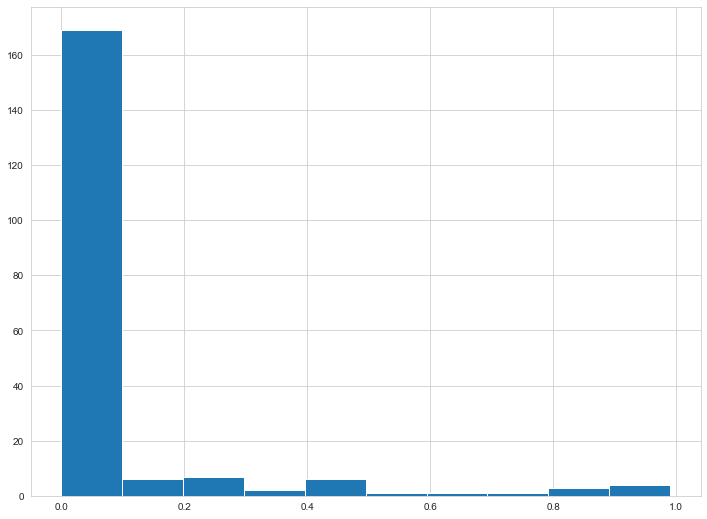

In [120]:
pd.Series(y_predicted_prob[:, 1]).hist() #изобразим

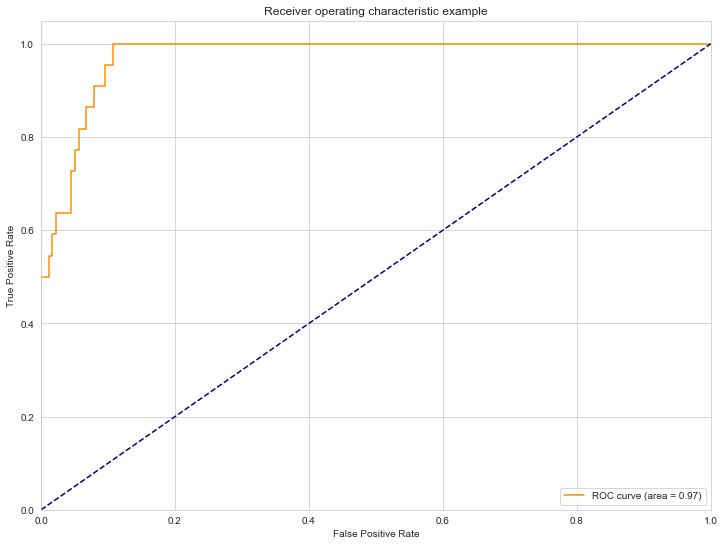

In [121]:
from sklearn.metrics import roc_curve, auc #изобразим ROC-кривую, пунктир - самый плохой вариант
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
roc_auc = auc(fpr, tpr)

In [122]:
roc_auc = auc(fpr, tpr) #площадь под кривой - все с нашей моделью ок
roc_auc

0.9729315628192032

## Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

### Это странно но ладно)  Люблю Florence and the Machine, Hozier, Kaleo, David Bowie

<font size=3 color='purple'><b>Итого: <font color='green'> 18 баллов</font>